In [1]:
from scipy.optimize import minimize
from qiskit import *
from qiskit.tools.monitor import job_monitor
import numpy as np
from scipy.optimize import minimize
from pylab import *

In [2]:
# z is a list containing exact eigenvalues for h = 0.1, 0.2,...,2.9 ,3 computed in Mathematica 
z = [-4.010037405062514 ,
-4.040593699203863,
-4.092961599426859,
-4.1691429451087645,
-4.271558410139714, 
-4.402568723322251,
-4.5638560652030025,
-4.755851777650323,
-4.977465611454963,
-5.226251859505506,
-5.498905492735204,
-5.791834638568259,
-6.1016033930386895,
-6.425177729100424,
-6.7600085505561465,
-7.104016521269247,
-7.455532355358033,
-7.813225255886913,
-8.176035456720664,
-8.543116820279428,
-8.913790457807169,
-9.287508263909395,
-9.663824636980378,
-10.042374672794756,
-10.422857362771913,
-10.805022618668234,
-11.188661210037163,
-11.573596918482796,
-11.959680383108838,
-12.34678424145734]

In [10]:
# Create a list consists of all 2^4 = 16 possible states for 4 qubits 
bit = ['0','1']
dic = []
for i in bit:
    for j in bit:
        for k in bit:
            for l in bit:
                dic.append(i+j+k+l)
dic                

['0000',
 '0001',
 '0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '1000',
 '1001',
 '1010',
 '1011',
 '1100',
 '1101',
 '1110',
 '1111']

In [8]:
# define functions to caculate expectation energy by counting probabilities in Quantum Virtual Simulator. 
# 1. Quantum_module_Z caculate expectation energy for terms of sigma z 
def module_Z(teta):
    q = QuantumRegister(4)
    c = ClassicalRegister(4)
    circuit = QuantumCircuit(q, c)

# quantum state preparation
    q = circuit.qregs[0]
# Uncomment these following 6 lines by pressing " CTRL / " to prepare ENTANGLE states of 4 qubits

#     circuit.u3(teta[4], teta[5], 0, q[0])
#     circuit.cx(q[0],q[1])
#     circuit.cx(q[0],q[2])
#     circuit.cx(q[0],q[3])
#     for i in range(3):
#         circuit.barrier(q[i])
    circuit.ry(teta[0], q[0])
    circuit.ry(teta[1], q[1])
    circuit.ry(teta[2], q[2])
    circuit.ry(teta[3], q[3])
    for i in range(3):
        circuit.barrier(q[i])


# measurement
    circuit.measure(range(4),range(4))
# Executing the circuit by qasm_simulation to caculate energy from result.get(counts)    
    shots = 10000
    backend = BasicAer.get_backend('qasm_simulator')
    result = execute(circuit, backend, shots=shots).result()
    counts = result.get_counts()
    
# get full possible keys for counts otherwise we might encounter KeyError where we count nothing for a key
# Remember dic is the list that contain all 2^4=16 possible keys, appending key for count where key in dic but not in count     
    for i in dic:
        if i not in counts:
            counts[i] = 0
# function to calculate probability
    def prob(j):
        e = 0
        for i in counts.keys():
            if i[j] == '0':
                e += counts[i]
            else:
                e -= counts[i]
        return e/shots 

    # expectation value of energy estimation from counts
    E_J = -prob(0)*prob(1) - prob(1)*prob(2) - prob(2)*prob(3) - prob(3)*prob(0)
    return E_J
# 2. Quantum_module_X caculate expectation energy for terms of sigma x
def module_X(teta):
    q = QuantumRegister(4)
    c = ClassicalRegister(4)
    circuit = QuantumCircuit(q, c)

# quantum state preparation
    q = circuit.qregs[0]
# Uncomment these following 6 lines by pressing " CTRL / " to prepare ENTANGLE states of 4 qubits
    
#     circuit.u3(teta[4], teta[5], 0, q[0])
#     circuit.cx(q[0],q[1])
#     circuit.cx(q[0],q[2])
#     circuit.cx(q[0],q[3])
#     for i in range(3):
#         circuit.barrier(q[i])
        
    circuit.ry(teta[0], q[0])
    circuit.ry(teta[1], q[1])
    circuit.ry(teta[2], q[2])
    circuit.ry(teta[3], q[3])
    for i in range(3):
        circuit.barrier(q[i])

# measurement 
# Add Hadamard gate before put measurement gate to change measurement axis from z to x 
    circuit.h(q[0])
    circuit.h(q[1])
    circuit.h(q[2])
    circuit.h(q[3])
    circuit.measure(range(4), range(4))
    
# Executing the circuit by qasm_simulation to caculate energy from result.get(counts)    

    shots = 10000
    backend = BasicAer.get_backend('qasm_simulator')
    result = execute(circuit, backend, shots=shots).result()
    counts = result.get_counts()

# get full possible keys for counts otherwise we might encounter KeyError where we count nothing for a key
# Remember dic is the list that contain all 2^4=16 possible keys, appending key for count where key in dic but not in count 
    
    for i in dic:
        if i not in counts:
            counts[i] = 0
# function to calculate probability
    def prob(j):
        e = 0
        for i in counts.keys():
            if i[j] == '0':
                e += counts[i]
            else:
                e -= counts[i]
        return e/shots 

# expectation value estimation from counts

    E_Z = -(prob(0)+prob(1)+prob(2)+prob(3))
    return E_Z

# expectation value total 
def vqe(teta):
    # Summing the measurement results
    classical_adder = module_Z(teta) + h * module_X(teta)
    return classical_adder


In [19]:
from numpy import random
l = np.pi*random.rand()

tol = 1e-3 # tolerance for optimization precision.
# Get expectation energy by optimization with corresponding h = 0.1, 0.2,..., 2.9, 3. 
y_vqe = []
for k in range(1,31):
    h = k/10
    vqe_result = minimize(vqe, [l]*6 , method="COBYLA", tol=tol)
    y_vqe.append(vqe_result.fun)

Text(0.5, 1.0, 'VQE vs Exact Diagonal')

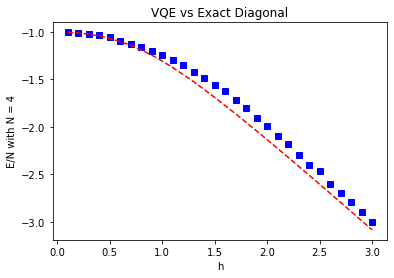

In [20]:
# Compare the ground state energy by using vqe and the exact results
# compare the average values E/4 
y_moi = np.array(y_vqe)/4
z_moi = np.array(z)/4
# 
x = []
for k in range(1,31):
    x.append(k/10)
    
plot(x,y_moi,'bs', label='VQE')
plot(x,z_moi, 'r--',label='Exact')

plt.xlabel('h')
plt.ylabel('E/N with N = 4')
plt.title('VQE vs Exact Diagonal')